**Installing Pyspark**

In [ ]:
!pip install pyspark

**Importing Libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, FMClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

**Creating the Spark Session**

In [ ]:
spark = SparkSession \
.builder \
.appName("Python Spark classification") \
.config("config.option", "value") \
.getOrCreate()

**Load The Data**

In [ ]:
filepath = "/content/bank (1).csv"
df = spark.read.csv(f'{filepath}', header = True, inferSchema = True)

In [ ]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

# **Exploratory Data Analysis**





In [ ]:
df.drop('day','month','poutcome').show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|     579|       1|   -1|       0|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|     673|       2|   -1|       0|    yes|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+-

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
bank_pandas = df.toPandas()

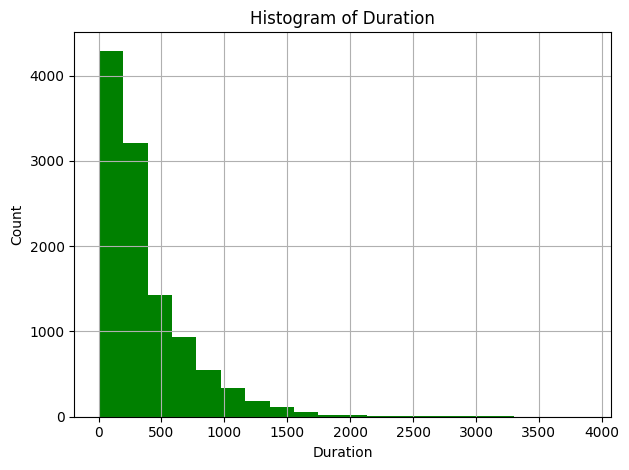

In [ ]:
bank_pandas.hist(column='duration', bins=20, color="g")
plt.title("Histogram of Duration")
plt.xlabel("Duration")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

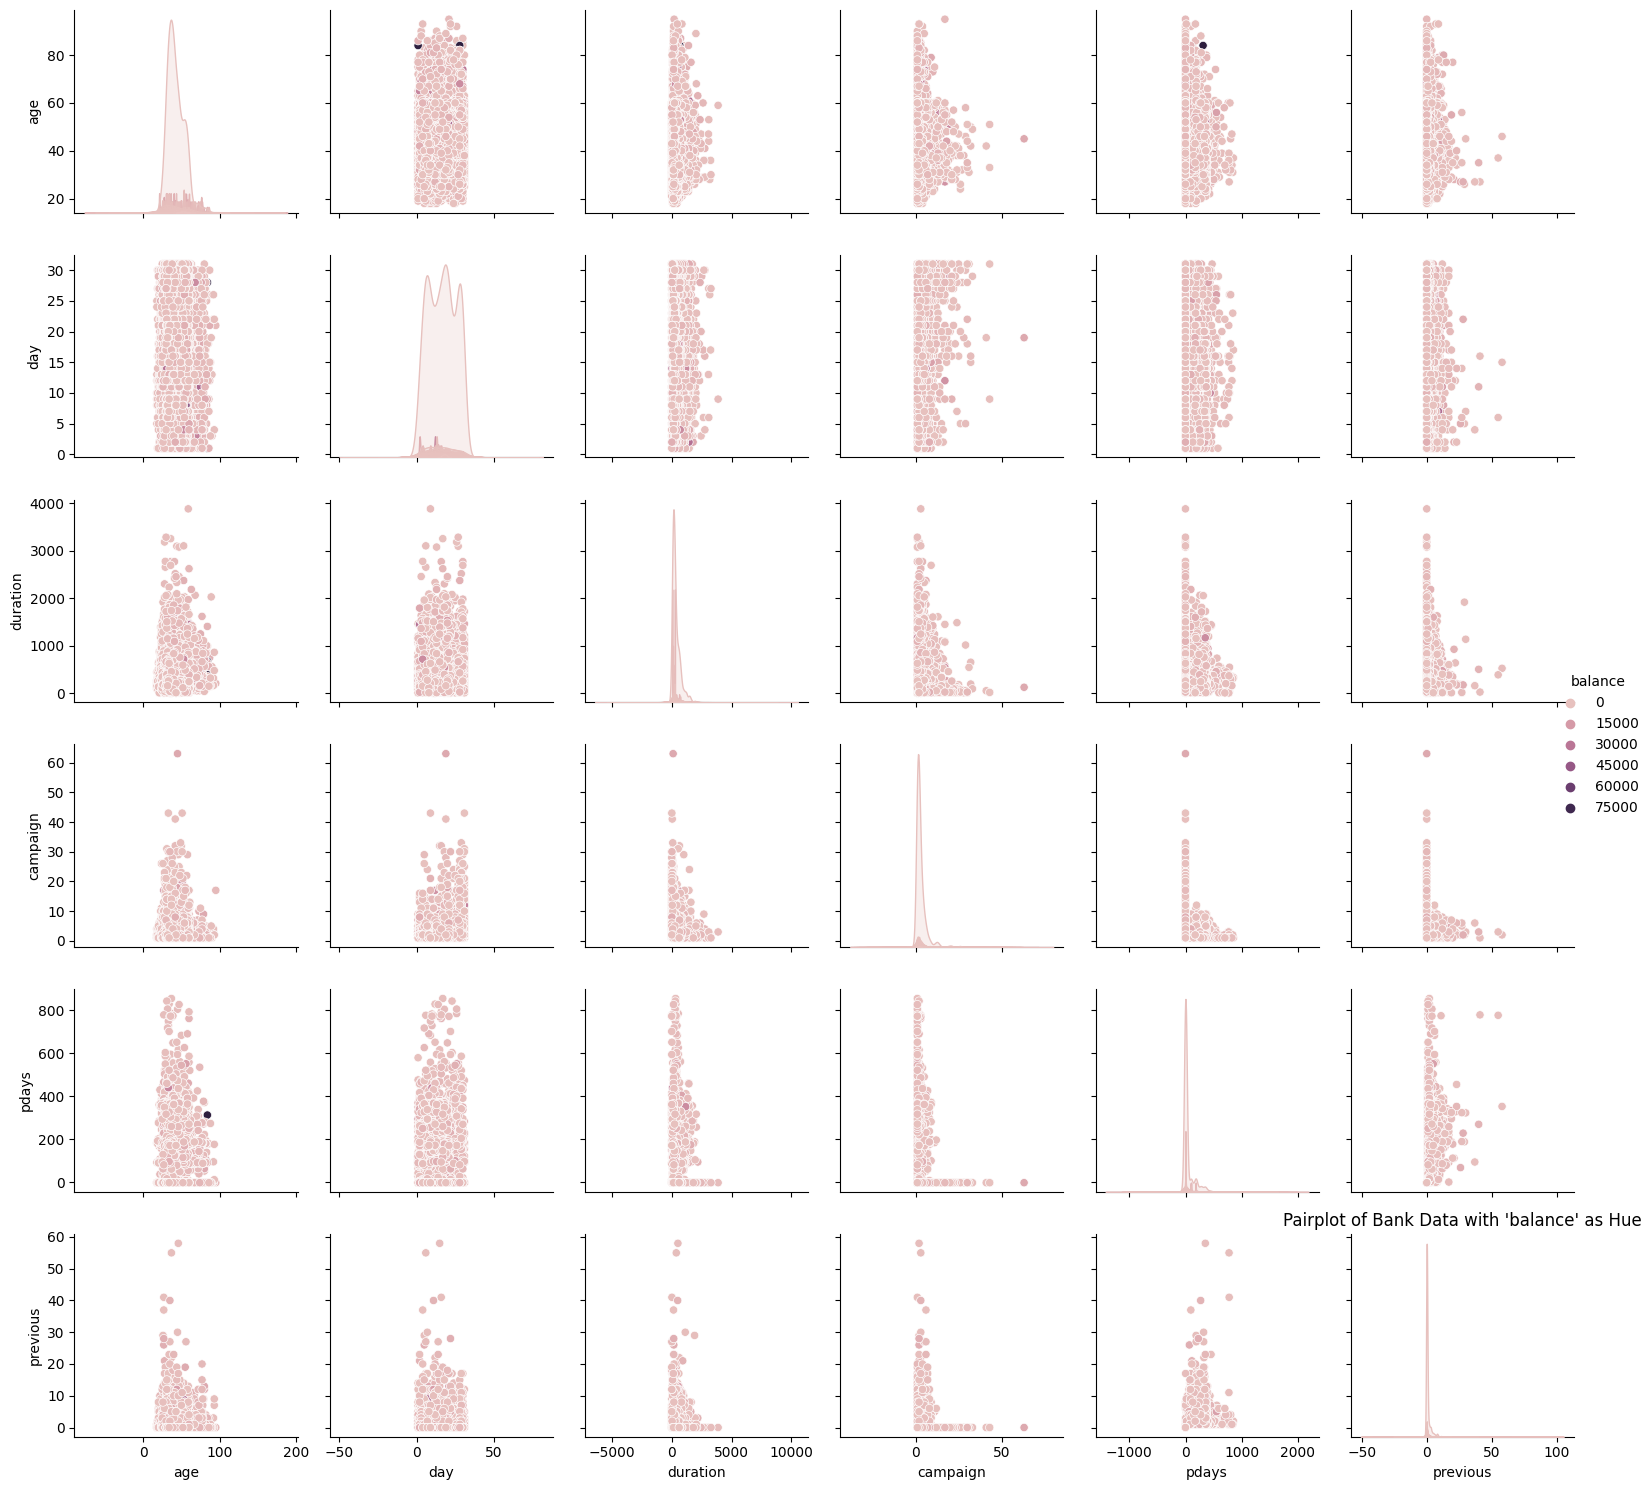

In [ ]:
sns.pairplot(bank_pandas, hue='balance')
plt.title("Pairplot of Bank Data with 'balance' as Hue")
plt.tight_layout()
plt.show()

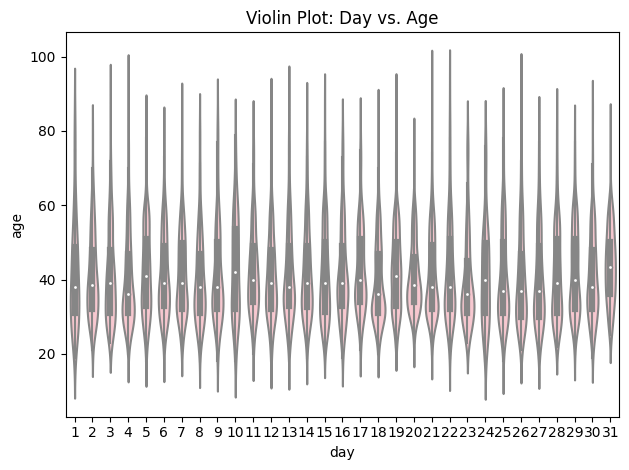

In [ ]:
sns.violinplot(data=bank_pandas, x='day', y='age', grid=True, color='pink')
plt.title("Violin Plot: Day vs. Age")
plt.tight_layout()
plt.show()

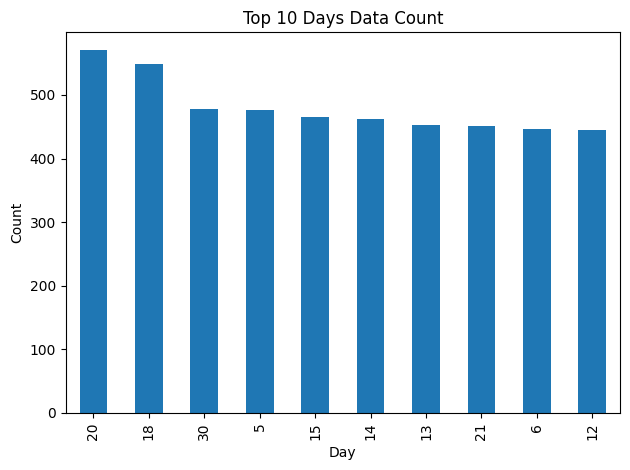

In [ ]:
ax = bank_pandas['day'].value_counts().head(10).plot(kind='bar', title='Top 10 days data count')
ax.set_xlabel('Day')
ax.set_ylabel('Count')
plt.title("Top 10 Days Data Count")
plt.tight_layout()
plt.show()

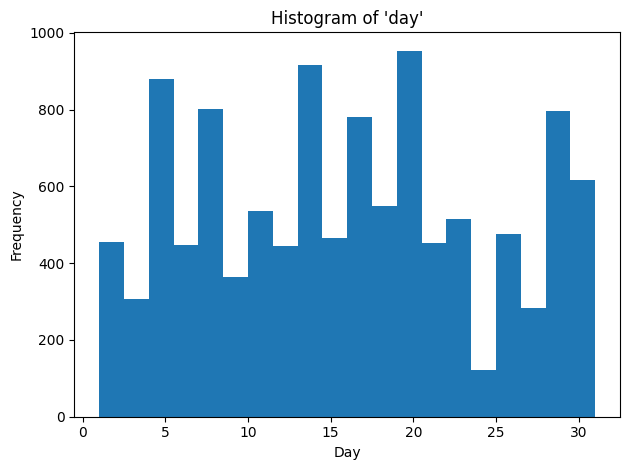

In [ ]:
ax = bank_pandas['day'].plot(kind='hist', bins=20, title='day')
ax.set_xlabel('Day')
plt.title("Histogram of 'day'")
plt.tight_layout()
plt.show()

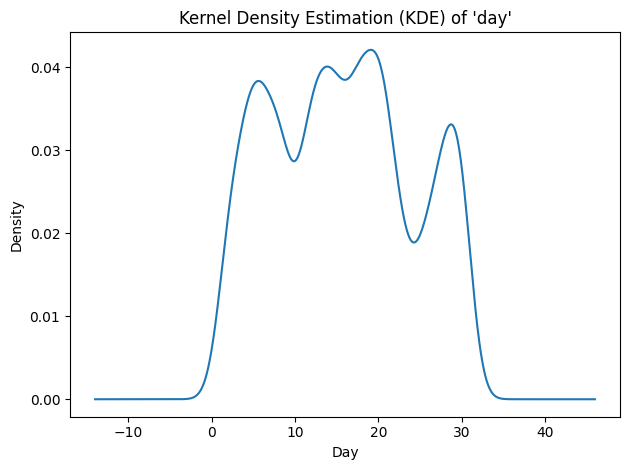

In [ ]:
ax = bank_pandas['day'].plot(kind='kde', title='total days')
ax.set_xlabel('Day')
plt.title("Kernel Density Estimation (KDE) of 'day'")
plt.tight_layout()
plt.show()

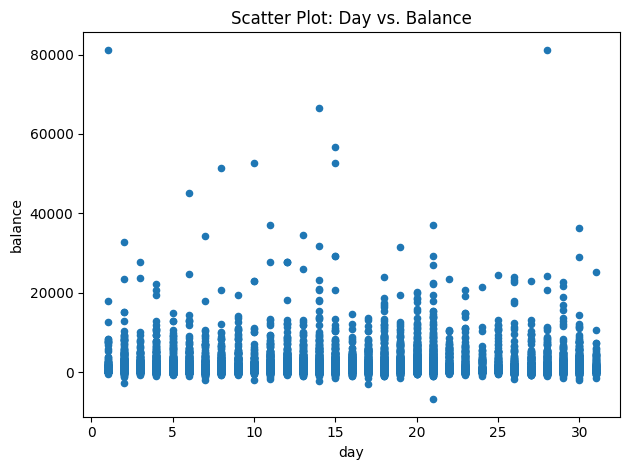

In [ ]:
bank_pandas.plot(kind='scatter', x='day', y='balance', title='balance')
plt.title("Scatter Plot: Day vs. Balance")
plt.tight_layout()
plt.show()

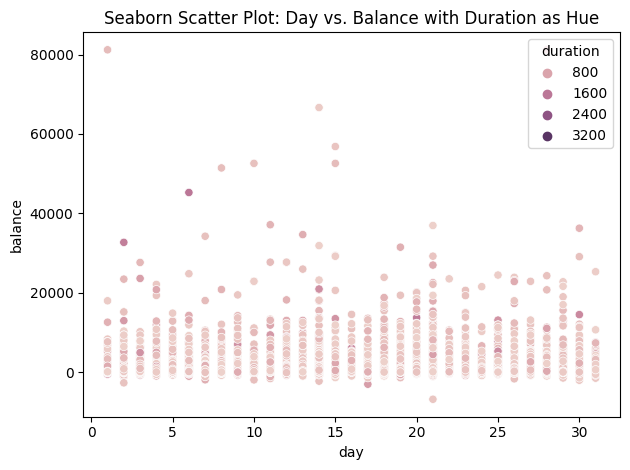

In [ ]:
ax = sns.scatterplot(x='day', y='balance', hue='duration', data=bank_pandas)
ax.set_title('Day vs. Balance')
plt.title("Seaborn Scatter Plot: Day vs. Balance with Duration as Hue")
plt.tight_layout()
plt.show()

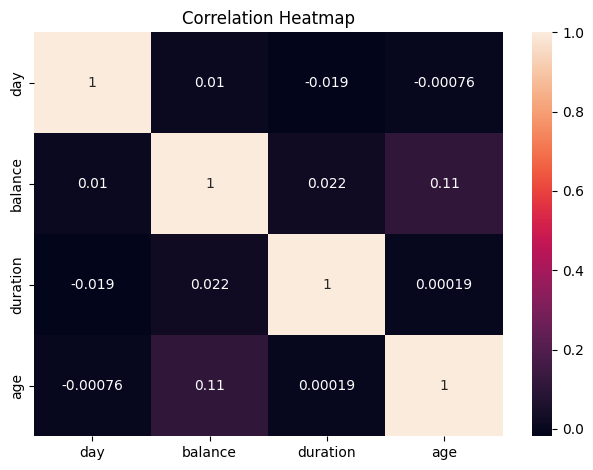

In [ ]:
bank_corr = bank_pandas[['day', 'balance', 'duration', 'age']].dropna().corr()
sns.heatmap(bank_corr, annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
unique_deposit_values = df.select("deposit").distinct().rdd.map(lambda row: row[0]).collect()

class_names = []
for value in unique_deposit_values:
    class_names.append(value)
print(class_names)

['no', 'yes']


**Categorical variable to dense vector**

In [ ]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

stages = []

for categoricalCol in categoricalColumns:

    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    stages += [stringIndexer, encoder]

In [ ]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
df.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[2,11,13,16,1...|
|  1.0|(30,[4,11,13,16,1...|
|  1.0|(30,[3,11,14,16,1...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)
data = featureIndexer.transform(df)

data.show(5, True)

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  1.0|(30,[3,11,13,16,1...|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|(30,[3,11,13,16,1...|
|  1.0|(30,[2,11,13,16,1...|(30,[2,11,13,16,1...|
|  1.0|(30,[4,11,13,16,1...|(30,[4,11,13,16,1...|
|  1.0|(30,[3,11,14,16,1...|(30,[3,11,14,16,1...|
+-----+--------------------+--------------------+
only showing top 5 rows



**Split Data into Train and Test Set**

In [ ]:
train_data, test_data = data.randomSplit([0.6, 0.4])

In [ ]:
train_data.show(5)

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
test_data.show(5)

+-----+--------------------+--------------------+
|label|            features|     indexedFeatures|
+-----+--------------------+--------------------+
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|(30,[0,11,13,16,1...|
+-----+--------------------+--------------------+
only showing top 5 rows



**Model Building, Confusion Matrix, Performance Evaluation Metrics**

In [ ]:
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
logr_model = logr.fit(train_data)

In [ ]:
logr_predict = logr_model.transform(test_data)

In [ ]:
logr_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[1.85841614768448...|       0.0|[0.86511223033374...|
|(30,[0,11,13,16,1...|  0.0|[1.86382141798718...|       0.0|[0.86574174396456...|
|(30,[0,11,13,16,1...|  0.0|[3.38928276966208...|       0.0|[0.96736791130217...|
|(30,[0,11,13,16,1...|  0.0|[-0.8712684733244...|       1.0|[0.29499042765577...|
|(30,[0,11,13,16,1...|  0.0|[0.09632615094072...|       0.0|[0.52406293449451...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
logr_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', logr_bn_evaluator.evaluate(logr_predict))

Test Area Under ROC: 0.8856983916223039


In [ ]:
logr_ml_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print('Test Accuracy:', logr_ml_evaluator.evaluate(logr_predict))

Test Accuracy: 0.804538305998652


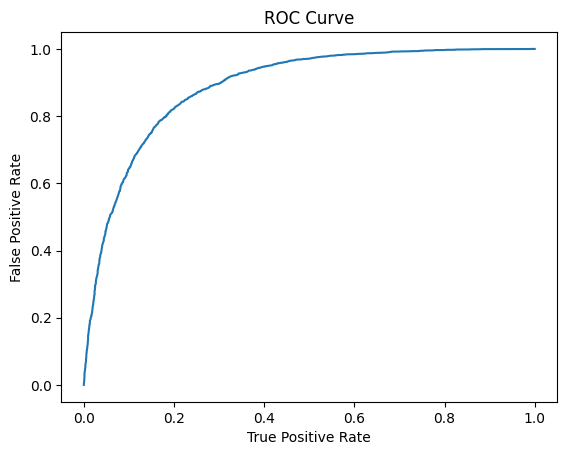

In [ ]:
roc = logr_model.summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

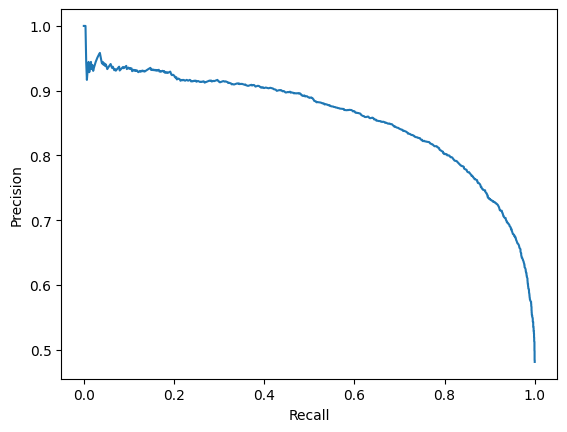

In [ ]:
pr = logr_model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
y_true = logr_predict.select("label")
y_true = y_true.toPandas()
y_pred = logr_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[2029,  362],
       [ 508, 1552]])

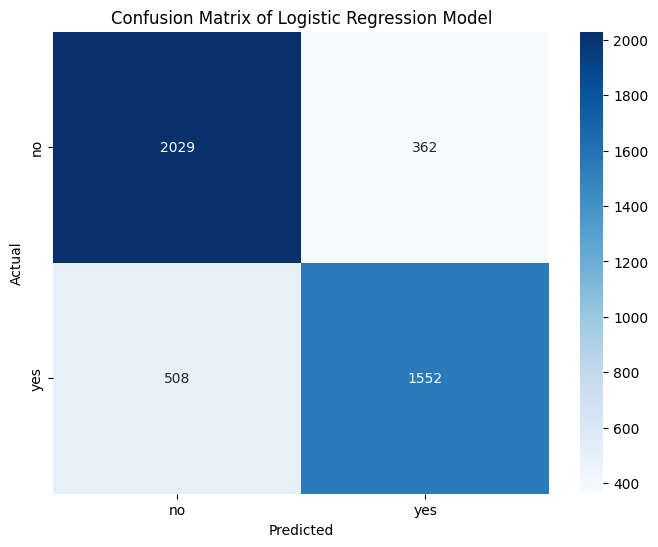

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Logistic Regression Model')
plt.show()

In [ ]:
dt = DecisionTreeClassifier(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
dt_model = dt.fit(train_data)

In [ ]:
dt_predict = dt_model.transform(test_data)

In [ ]:
dt_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+-------------+----------+--------------------+
|            features|label|rawPrediction|prediction|         probability|
+--------------------+-----+-------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0| [794.0,29.0]|       0.0|[0.96476306196840...|
|(30,[0,11,13,16,1...|  0.0|[401.0,599.0]|       1.0|       [0.401,0.599]|
|(30,[0,11,13,16,1...|  0.0| [794.0,29.0]|       0.0|[0.96476306196840...|
|(30,[0,11,13,16,1...|  0.0|[199.0,677.0]|       1.0|[0.22716894977168...|
|(30,[0,11,13,16,1...|  0.0|[401.0,599.0]|       1.0|       [0.401,0.599]|
+--------------------+-----+-------------+----------+--------------------+
only showing top 5 rows



In [ ]:
dt_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', dt_bn_evaluator.evaluate(dt_predict))

Test Area Under ROC: 0.828865121227256


In [ ]:
dt_ml_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print('Test Accuracy:', dt_ml_evaluator.evaluate(dt_predict))

Test Accuracy: 0.7977982475848124


In [ ]:
y_true = dt_predict.select("label")
y_true = y_true.toPandas()
y_pred = dt_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1818,  573],
       [ 327, 1733]])

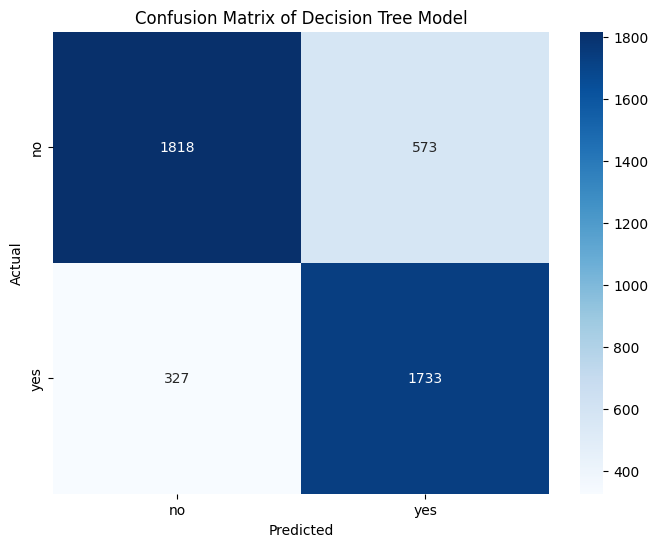

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Decision Tree Model')
plt.show()

In [ ]:
rf = RandomForestClassifier(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
rf_model = rf.fit(train_data)

In [ ]:
rf_predict = rf_model.transform(test_data)

In [ ]:
rf_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[14.2038799577101...|       0.0|[0.71019399788550...|
|(30,[0,11,13,16,1...|  0.0|[12.4954843484495...|       0.0|[0.62477421742247...|
|(30,[0,11,13,16,1...|  0.0|[14.1394621265905...|       0.0|[0.70697310632952...|
|(30,[0,11,13,16,1...|  0.0|[6.46793022858748...|       1.0|[0.32339651142937...|
|(30,[0,11,13,16,1...|  0.0|[10.8217728041199...|       0.0|[0.54108864020599...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
rf_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', rf_bn_evaluator.evaluate(rf_predict))

Test Area Under ROC: 0.87966819342762


In [ ]:
rf_ml_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print('Test Accuracy:', rf_ml_evaluator.evaluate(rf_predict))

Test Accuracy: 0.8061109862952146


In [ ]:
y_true = rf_predict.select("label")
y_true = y_true.toPandas()
y_pred = rf_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1996,  395],
       [ 468, 1592]])

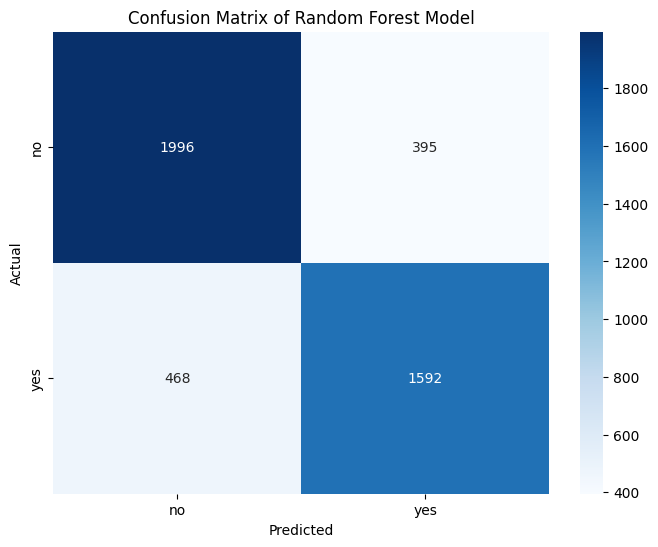

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Random Forest Model')
plt.show()

In [ ]:
gbt = GBTClassifier(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
gbt_model = gbt.fit(train_data)

In [ ]:
gbt_predict = gbt_model.transform(test_data)

In [ ]:
gbt_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[1.36840858698693...|       0.0|[0.93916450136545...|
|(30,[0,11,13,16,1...|  0.0|[0.39604863181912...|       0.0|[0.68828147626283...|
|(30,[0,11,13,16,1...|  0.0|[1.54242400887785...|       0.0|[0.95626339580991...|
|(30,[0,11,13,16,1...|  0.0|[-0.6320629056307...|       1.0|[0.22026447448187...|
|(30,[0,11,13,16,1...|  0.0|[-0.1052165533883...|       1.0|[0.44758500119026...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
gbt_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', gbt_bn_evaluator.evaluate(gbt_predict))

Test Area Under ROC: 0.8911511818185526


In [ ]:
gbt_ml_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print('Test Accuracy:', gbt_ml_evaluator.evaluate(gbt_predict))

Test Accuracy: 0.8189170972815097


In [ ]:
y_true = gbt_predict.select("label")
y_true = y_true.toPandas()
y_pred = gbt_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1940,  451],
       [ 355, 1705]])

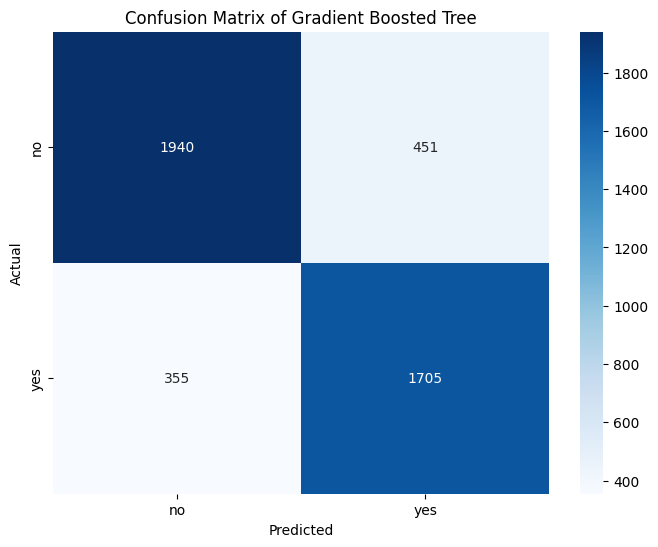

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Gradient Boosted Tree')
plt.show()

In [ ]:
svc = LinearSVC(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
svc_model = svc.fit(train_data)

In [ ]:
svc_predict = svc_model.transform(test_data)

In [ ]:
print("Coefficients: " + str(svc_model.coefficients))
print("Intercept: " + str(svc_model.intercept))

Coefficients: [0.09579455812135451,0.0014987682401827137,0.15464966493083074,0.3405107985096729,0.04736313379159746,0.747682326135246,-0.0811993112281332,1.2664619492153313,0.2102812897787526,0.040657586236436116,-0.11689948390033002,0.012639901017538072,0.1959417213707706,0.03352180549540778,0.2417715935175249,-0.1709616135076206,0.2246355747771254,0.5270388782245975,0.346230659420631,0.023098698048848832,-0.7682259092565191,-0.4155556315478721,-0.18220297535515084,1.4023269393655566,0.00041948009003736354,2.872831979158481e-05,0.004373537143267397,-0.07636395759348641,-3.731193818685469e-06,0.03493726826217501]
Intercept: -2.2566396739560814


In [ ]:
fm = FMClassifier(featuresCol='indexedFeatures', labelCol='label')

In [ ]:
fm_model = fm.fit(train_data)

In [ ]:
fm_predict = fm_model.transform(test_data)

In [ ]:
fm_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[382.669283725405...|       0.0|[1.0,6.4393448566...|
|(30,[0,11,13,16,1...|  0.0|[1267.39227900086...|       0.0|           [1.0,0.0]|
|(30,[0,11,13,16,1...|  0.0|[2311.31738608589...|       0.0|           [1.0,0.0]|
|(30,[0,11,13,16,1...|  0.0|[3631.91047309842...|       0.0|           [1.0,0.0]|
|(30,[0,11,13,16,1...|  0.0|[1832.43721612106...|       0.0|           [1.0,0.0]|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
fm_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', fm_bn_evaluator.evaluate(fm_predict))

Test Area Under ROC: 0.585659207464887


In [ ]:
fm_ml_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print('Test Accuracy:', fm_ml_evaluator.evaluate(fm_predict))

Test Accuracy: 0.5933498090316782


In [ ]:
y_true = fm_predict.select("label")
y_true = y_true.toPandas()
y_pred = fm_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1635,  756],
       [1054, 1006]])

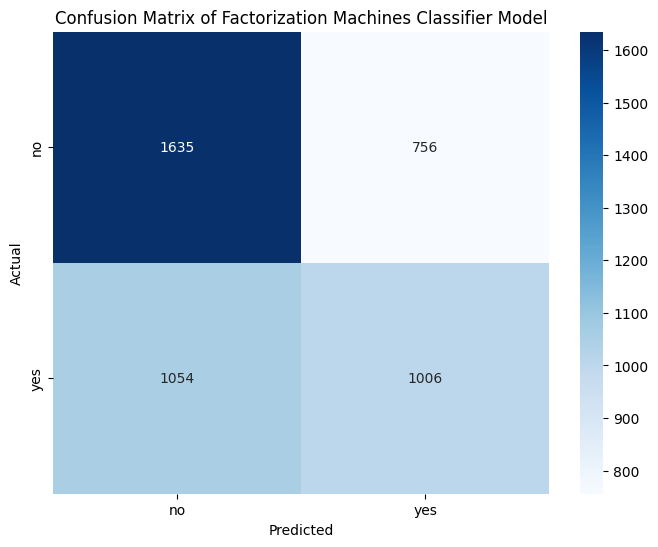

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Factorization Machines Classifier Model')
plt.show()

In [ ]:
nb = NaiveBayes(modelType='gaussian',
    smoothing=0.1)

In [ ]:
nb_model = nb.fit(train_data)

In [ ]:
nb_predict = nb_model.transform(test_data)

In [ ]:
nb_predict.select("features","label","rawPrediction","prediction","probability").show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(30,[0,11,13,16,1...|  0.0|[-1.2950926721577...|       0.0|[0.95848431526168...|
|(30,[0,11,13,16,1...|  0.0|[-4.2154930167722...|       0.0|[0.99997870364051...|
|(30,[0,11,13,16,1...|  0.0|[-11.344224822050...|       0.0|[0.99999999998077...|
|(30,[0,11,13,16,1...|  0.0|[-2.5557322549349...|       1.0|[0.42768250817452...|
|(30,[0,11,13,16,1...|  0.0|[-1.2639336594711...|       0.0|[0.70809926969158...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [ ]:
nb_bn_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC:', nb_bn_evaluator.evaluate(nb_predict))

Test Area Under ROC: 0.556187848444612


In [ ]:
nb_ml_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print('Test Accuracy:', nb_ml_evaluator.evaluate(nb_predict))

Test Accuracy: 0.7371377218602562


In [ ]:
y_true = nb_predict.select("label")
y_true = y_true.toPandas()
y_pred = nb_predict.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1913,  478],
       [ 692, 1368]])

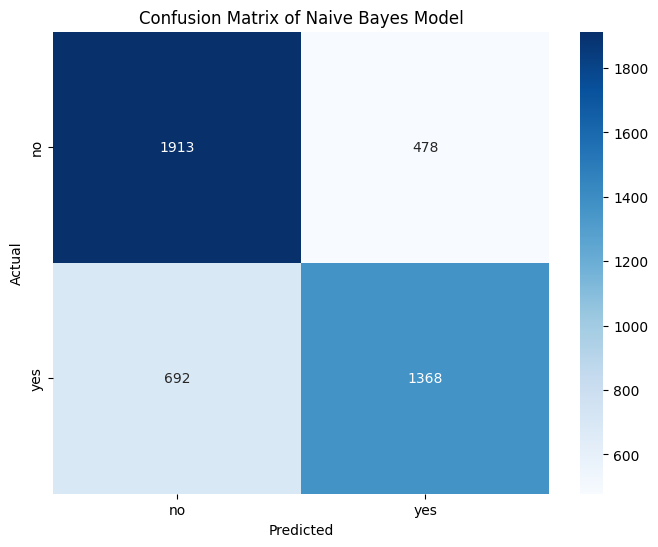

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Naive Bayes Model')
plt.show()

**Comparing the Results**

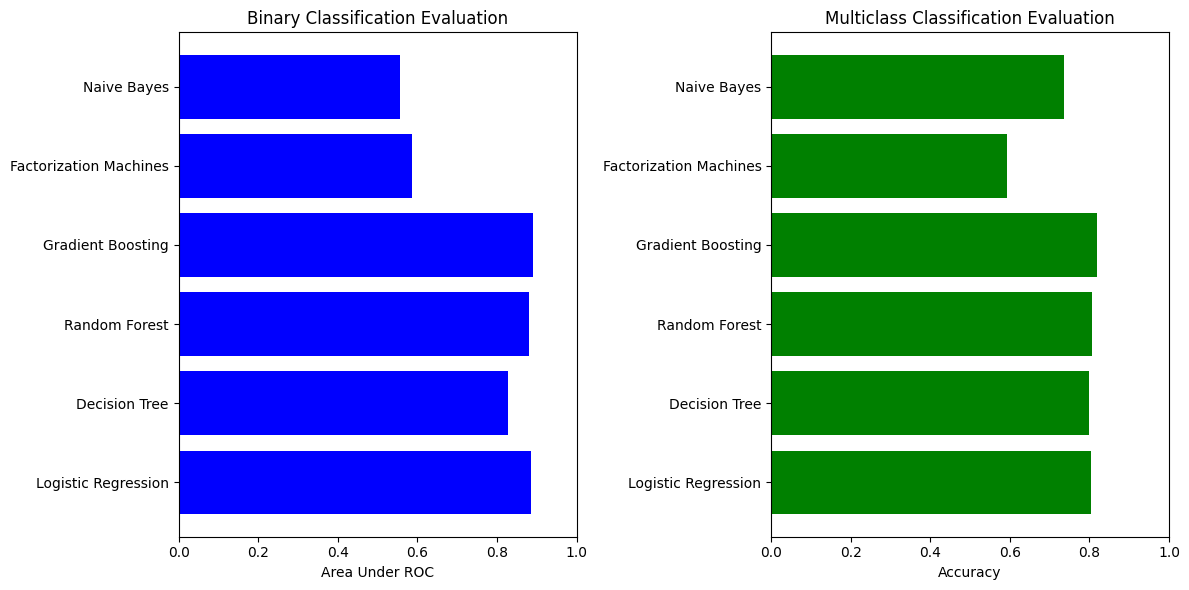

In [ ]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Factorization Machines', 'Naive Bayes']
areaUnderROC = [logr_bn_evaluator.evaluate(logr_predict), dt_bn_evaluator.evaluate(dt_predict), rf_bn_evaluator.evaluate(rf_predict), gbt_bn_evaluator.evaluate(gbt_predict), fm_bn_evaluator.evaluate(fm_predict), nb_bn_evaluator.evaluate(nb_predict)]
accuracy = [logr_ml_evaluator.evaluate(logr_predict), dt_ml_evaluator.evaluate(dt_predict), rf_ml_evaluator.evaluate(rf_predict), gbt_ml_evaluator.evaluate(gbt_predict), fm_ml_evaluator.evaluate(fm_predict), nb_ml_evaluator.evaluate(nb_predict)]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(models, areaUnderROC, color='b')
plt.xlabel('Area Under ROC')
plt.title('Binary Classification Evaluation')
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
plt.barh(models, accuracy, color='g')
plt.xlabel('Accuracy')
plt.title('Multiclass Classification Evaluation')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()